In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('../notebooks/style.mpl')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Respiratory heterotrophy model

In [46]:
eps = 1e-10
tau = 1e0
S2 = 2.

In [47]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = 0.0
    x[x>1e8] = 1e8
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP
    
    nu_cat = phi_cat * gamma_cat_inv * tau
    nu_resp = phi_resp * gamma_resp_inv * tau
    nu_ana = phi_ana * gamma_ana_inv * tau
    
    mu = nu_ana
    Jh = phi_h * gamma_hom_inv * tau
    
    # dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dCorg = 0.0
    dNADH = S2 * nu_cat - 2 * nu_resp - S6 * nu_ana - mu * NADH
    # dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = S3 * nu_cat + S4 * nu_resp - S5 * nu_ana  - Jh - maint - mu * ATP
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

# Simulations

### Parameters

In [118]:
# gamma inverses are in /hr units.
gamma_cat_inv = 0.5
gamma_resp_inv = 2.0
gamma_ana_inv = 0.5
gamma_hom_inv = 0.5

phi_cat = 0.3
phi_ana = 0.2
phi_resp = 0.03
phi_h = 0.0
phi_o = 1 - (phi_cat + phi_ana + phi_resp + phi_h)

# maintenance energy
maint = 0.01

# Default params: reliance on respiration.
S4 = 1.0    # ATP yield of respiration
S3 = 0.5    # ATP yield of catabolism
S5 = 0.3    # ATP cost of anabolism
S6 = 0.1    # reduction coefficient of biomass

### Initial conditions

In [119]:
# concentrations in KM units
Corg0 = 1e2
NADH0 = 1e-1
O20 = 1e1
ATP0 = 1e0

# KM is in uM
KM = 100
r1 = 10.
r2 = 0.1

### Dynamics

In [120]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 6, 1000 )
S6 = 0.1

In [121]:
def give_nus( y_sol, tpt ):
    x = y_sol[:, tpt].copy()
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]

    NAD = r1 * NADH
    ADP = r2 * ATP

    nu_cat = phi_cat * gamma_cat_inv * tau
    nu_resp = phi_resp * gamma_resp_inv * tau
    nu_ana = phi_ana * gamma_ana_inv * tau
    
    mu = nu_ana
    Jh = phi_h * gamma_hom_inv * tau
    
    return np.array([nu_cat, nu_resp, nu_ana])

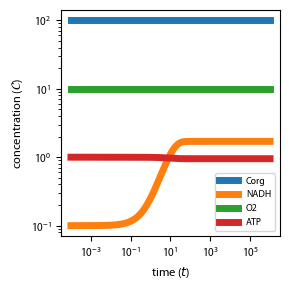

In [122]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=5 )
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

In [123]:
def is_steady(y_sol, eps):
    # Check if solution has reached steady state
    # by checking if the values at index 1 and -1 are constant and above eps
    return y_sol[1,-1] > eps and y_sol[-1,-1] > eps and np.abs(np.diff(y_sol[1,:]))[-1] < eps and np.abs(np.diff(y_sol[-1,:]))[-1] < eps

In [124]:
is_steady(y_sol, 1e-4)

True

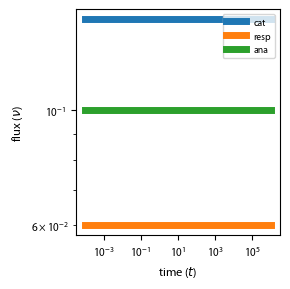

In [125]:
nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'flux (' + r'$\nu$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(3):
    ax.plot( t[:len(nus[idx])], nus[idx], lw=5 )
ax.legend([ 'cat', 'resp', 'ana' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

# Variable $\phi_h$

In [359]:
opt_atps = []
opt_nadhs = []
opt_mus = []
opt_phi_cats = []
opt_phi_resps = []
opt_phi_anas = []
opt_phi_hs = []
opt_phi_os = []
s6s = []

# concentrations in KM units
NADH0 = 1e-1
ATP0 = 1e-1

eps = 1e-4 # define your own value for eps here

# Set fixed values for phi_o and maintenance
phi_o = 0.2
maint = 0.00

for S6 in np.linspace(-5, 1, 10):
    anas_to_sample = np.linspace(0.00, 0.9, 40)
    resps_to_sample = np.linspace(0.00, 0.5, 12)
    cats_to_sample = np.linspace(0.0, 0.05, 10)

    allatps, allnadhs, allmus, allphis = [], [], [], []
    for phi_ana in anas_to_sample:
        for phi_resp in resps_to_sample:
            for phi_cat in cats_to_sample:
                phi_h = 1 - phi_cat - phi_resp - phi_ana - phi_o
                # make sure that phi_h is positive.
                if phi_h < 0:
                    continue

                y0 = np.array([Corg0, NADH0, O20, ATP0])
                NUM_METS = len(y0)

                # Evaluation time
                TFINAL = 1e6
                t = np.logspace(-4, 6, 1000)

                y_sol = solve_ivp(het_model, [1e-4, TFINAL], y0, t_eval=t, method='Radau').y

                if is_steady(y_sol, eps):
                    nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

                    allatps.append(y_sol[-1, -1])
                    allnadhs.append(y_sol[1, -1])
                    allmus.append(nus[-1, -1])
                    allphis.append([phi_cat, phi_resp, phi_ana, phi_h, phi_o])

    if len(allmus) > 0:
        mus = np.array(allmus)
        max_index = np.argmax(mus)  # finding growth-optimal index
        phi_cat, phi_resp, phi_ana, phi_h, phi_o = allphis[max_index]  # optimal phis

        # storing optimized ATP*, NADH* and optimal phi_resp.
        opt_atps.append(allatps[max_index])
        opt_nadhs.append(allnadhs[max_index])
        opt_phi_cats.append(phi_cat)
        opt_phi_resps.append(phi_resp)
        opt_phi_anas.append(phi_ana)
        opt_phi_hs.append(phi_h)
        opt_phi_os.append(phi_o)
        opt_mus.append(allmus[max_index])
        s6s.append(S6)

df = pd.DataFrame({'atps': opt_atps,
                   'nadhs': opt_nadhs,
                   's6s': s6s,
                   'mus': opt_mus,
                   'opt_phi_cat': opt_phi_cats,
                   'opt_phi_resp': opt_phi_resps,
                   'opt_phi_ana': opt_phi_anas,
                   'opt_phi_h': opt_phi_hs,
                   'opt_phi_o': opt_phi_os
                   })


In [ ]:
df

,atps,nadhs,s6s,mus,opt_phi_cat,opt_phi_resp,opt_phi_ana,opt_phi_h,opt_phi_o
0,0.222677,3.978384,-5.000000,0.346154,0.010000,0.090909,0.692308,0.006783,0.2
1,0.222677,3.311717,-4.333333,0.346154,0.010000,0.090909,0.692308,0.006783,0.2
2,0.222677,2.645051,-3.666667,0.346154,0.010000,0.090909,0.692308,0.006783,0.2
3,0.222677,1.978384,-3.000000,0.346154,0.010000,0.090909,0.692308,0.006783,0.2
4,0.222677,1.311717,-2.333333,0.346154,0.010000,0.090909,0.692308,0.006783,0.2
5,0.222677,0.645051,-1.666667,0.346154,0.010000,0.090909,0.692308,0.006783,0.2
6,0.043669,0.743939,-1.000000,0.323077,0.099091,0.045455,0.646154,0.009301,0.2
7,0.043669,0.077273,-0.333333,0.323077,0.099091,0.045455,0.646154,0.009301,0.2
8,0.012576,1.061212,0.333333,0.230769,0.321818,0.000000,0.461538,0.016643,0.2
9,0.012576,0.394545,1.000000,0.230769,0.321818,0.000000,0.461538,0.016643,0.2


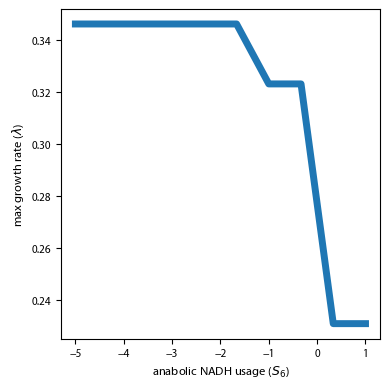

In [ ]:
fig, ax = plt.subplots( 1, 1, figsize=(4, 4) )

ax.set_ylabel( 'max growth rate (' + r'$\lambda$)')
ax.set_xlabel( 'anabolic NADH usage (' + r'$S_6$)')
ax.plot( df['s6s'], df['mus'], lw=5 )

fig.tight_layout()
plt.show()

## Testing dynamics for some sample combinations

In [352]:
phi_cat = 0.1
phi_ana = 0.7
phi_resp = 0.0
phi_h = 0.0

phi_o = 0.2
maint = 0.00

S6 = -4

In [353]:
phi_h

0.0

In [354]:
# concentrations in KM units
Corg0 = 1e2
NADH0 = 1e-1
O20 = 1e1
ATP0 = 1e-1

In [355]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 6, 1000 )

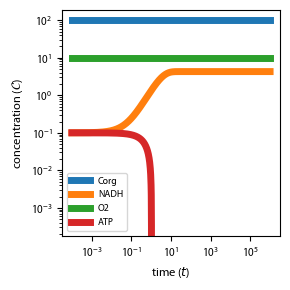

In [356]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=5 )
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

In [357]:
y_sol[[1,-1], -1]

array([ 4.28571429e+00, -7.99999170e+04])

In [358]:
is_steady(y_sol, eps)

False